<a href="https://colab.research.google.com/github/andreidm92/computer_vision_tasks/blob/main/projects%20/football_detection_segmentation/footbal_detection_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Установка необходимых библиотек
!pip install -q ultralytics
!pip install -q deep_sort_realtime opencv-python-headless

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 26.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 76.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 66.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 114.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 79.0 MB/s eta 0:00:00


[Frame 0] Детекций футболистов: 14
[Frame 30] Детекций футболистов: 12
[Frame 60] Детекций футболистов: 13
[Frame 90] Детекций футболистов: 15


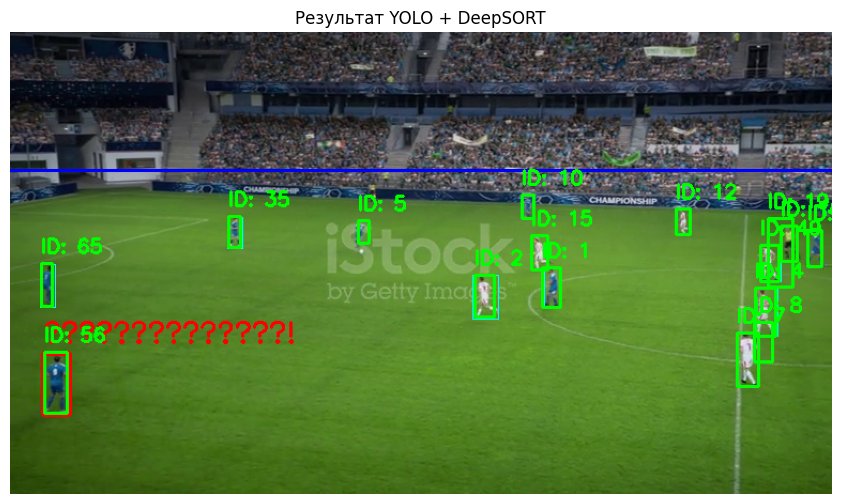

[Frame 120] Детекций футболистов: 11
[Frame 150] Детекций футболистов: 12
[Frame 180] Детекций футболистов: 8
[Frame 210] Детекций футболистов: 9
[Frame 240] Детекций футболистов: 7
[Frame 270] Детекций футболистов: 7
[Frame 300] Детекций футболистов: 13
[Frame 330] Детекций футболистов: 13
[Frame 360] Детекций футболистов: 8
[Frame 390] Детекций футболистов: 13
[Frame 420] Детекций футболистов: 14
[Frame 450] Детекций футболистов: 12
[Frame 480] Детекций футболистов: 14
[Frame 510] Детекций футболистов: 13
[Frame 540] Детекций футболистов: 14
[Frame 570] Детекций футболистов: 15
[Frame 600] Детекций футболистов: 12
[Frame 630] Детекций футболистов: 11
[Frame 660] Детекций футболистов: 11
[Frame 690] Детекций футболистов: 9
[Frame 720] Детекций футболистов: 6
[Frame 750] Детекций футболистов: 6
[Frame 780] Детекций футболистов: 7


In [3]:
# Импорты
import cv2
from ultralytics import YOLO
from deep_sort_realtime.deepsort_tracker import DeepSort
import numpy as np
import matplotlib.pyplot as plt

# Загрузка модели YOLOv8
model = YOLO('yolov8n.pt')  # Можно заменить на yolov8s.pt для более точной модели

# Загрузка видео
video_path = '/content/football.mp4'
cap = cv2.VideoCapture(video_path)

# Видео параметры
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter('tracked_output.mp4', fourcc, fps, (width, height))

# Инициализация DeepSORT
tracker = DeepSort(max_age=30)

frame_id = 0

# Проход по кадрам
while True:
    ret, frame = cap.read()
    if not ret:
        break

    results = model(frame, verbose=False, conf=0.25)[0]  # было по умолчанию ~0.5

    detections = []
    for box in results.boxes:
        cls_id = int(box.cls[0])
        if cls_id != 0:  # Только люди
            continue
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        conf = float(box.conf[0])
        detections.append(([x1, y1, x2 - x1, y2 - y1], conf, 'person'))


    # ROI: только нижняя половина изображения
    field_line = int(frame.shape[0] * 0.3)
    cv2.line(frame, (0, field_line), (frame.shape[1], field_line), (255, 0, 0), 2)

    players_on_field = [d for d in detections if d[0][1] > field_line]
    if frame_id % 30 == 0:  # Например, каждые 30 кадров
      print(f"[Frame {frame_id}] Детекций футболистов: {len(players_on_field)}")

    # Рисуем все детекции футболистов, прошедших ROI-фильтр
    for d in players_on_field:
        x, y, w, h = d[0]
        cv2.rectangle(frame, (x, y), (x + w, y + h), (255, 255, 0), 1)

    # Самый крупный игрок
    if players_on_field:
        largest = max(players_on_field, key=lambda d: d[0][2] * d[0][3])
        x, y, w, h = largest[0]
        cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 0, 255), 3)
        cv2.putText(frame, "Толстяк!", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 255), 2)

    # Трекинг
    tracks = tracker.update_tracks(players_on_field, frame=frame)

    for track in tracks:
        if not track.is_confirmed():
            continue
        track_id = track.track_id
        ltrb = track.to_ltrb()
        x1, y1, x2, y2 = map(int, ltrb)
        cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(frame, f'ID: {track_id}', (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

    # Показываем только первый кадр
    if frame_id == 100:
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(12, 6))
        plt.imshow(frame_rgb)
        plt.axis("off")
        plt.title("Результат YOLO + DeepSORT")
        plt.show()

    out.write(frame)
    frame_id += 1

cap.release()
out.release()


⚙️ Шаги для добавления SAM-сегментации


✅ Шаг 1. Установка SAM и зависимостей (Colab)
В отдельной ячейке:

In [4]:
!pip install -q git+https://github.com/facebookresearch/segment-anything.git
!pip install -q opencv-python-headless
!pip install -q torch torchvision


  Preparing metadata (setup.py) ... done


✅ Шаг 2. Загрузка модели SAM

In [5]:
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth -O sam_vit_b.pth


--2025-06-08 17:56:01--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.226.210.25, 13.226.210.78, 13.226.210.15, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.226.210.25|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 375042383 (358M) [binary/octet-stream]
Saving to: ‘sam_vit_b.pth’

sam_vit_b.pth       100%[===================>] 357.67M   143MB/s    in 2.5s    

2025-06-08 17:56:03 (143 MB/s) - ‘sam_vit_b.pth’ saved [375042383/375042383]



In [6]:
import torch
from segment_anything import sam_model_registry, SamPredictor

# Скачай заранее или используй путь, если в Colab
sam_checkpoint = "sam_vit_b.pth"  # Скачай файл с https://github.com/facebookresearch/segment-anything

device = "cuda" if torch.cuda.is_available() else "cpu"
sam = sam_model_registry["vit_b"](checkpoint=sam_checkpoint)
sam.to(device)
predictor = SamPredictor(sam)


✅ Шаг 3. Вставь в цикл while после players_on_field = [...]:

[Frame 0] Детекций футболистов: 14
[Frame 30] Детекций футболистов: 12
[Frame 60] Детекций футболистов: 13
[Frame 90] Детекций футболистов: 15


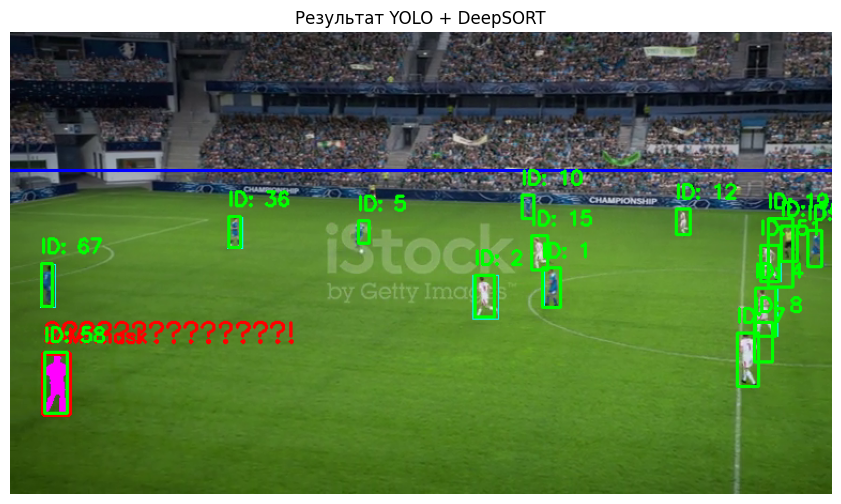

[Frame 120] Детекций футболистов: 11
[Frame 150] Детекций футболистов: 12
[Frame 180] Детекций футболистов: 8
[Frame 210] Детекций футболистов: 9
[Frame 240] Детекций футболистов: 7
[Frame 270] Детекций футболистов: 7
[Frame 300] Детекций футболистов: 13
[Frame 330] Детекций футболистов: 13
[Frame 360] Детекций футболистов: 8
[Frame 390] Детекций футболистов: 13
[Frame 420] Детекций футболистов: 14
[Frame 450] Детекций футболистов: 12
[Frame 480] Детекций футболистов: 14
[Frame 510] Детекций футболистов: 13
[Frame 540] Детекций футболистов: 14
[Frame 570] Детекций футболистов: 15
[Frame 600] Детекций футболистов: 12
[Frame 630] Детекций футболистов: 11
[Frame 660] Детекций футболистов: 11
[Frame 690] Детекций футболистов: 9
[Frame 720] Детекций футболистов: 6
[Frame 750] Детекций футболистов: 6
[Frame 780] Детекций футболистов: 7


In [7]:
# Импорты
import cv2
from ultralytics import YOLO
from deep_sort_realtime.deepsort_tracker import DeepSort
import numpy as np
import matplotlib.pyplot as plt

# Загрузка модели YOLOv8
model = YOLO('yolov8n.pt')  # Можно заменить на yolov8s.pt для более точной модели

# Загрузка видео
video_path = '/content/football.mp4'
cap = cv2.VideoCapture(video_path)

# Видео параметры
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter('tracked_output.mp4', fourcc, fps, (width, height))

# Инициализация DeepSORT
tracker = DeepSort(max_age=30)

frame_id = 0

# Проход по кадрам
while True:
    ret, frame = cap.read()
    if not ret:
        break

    results = model(frame, verbose=False, conf=0.25)[0]  # было по умолчанию ~0.5

    detections = []
    for box in results.boxes:
        cls_id = int(box.cls[0])
        if cls_id != 0:  # Только люди
            continue
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        conf = float(box.conf[0])
        detections.append(([x1, y1, x2 - x1, y2 - y1], conf, 'person'))


    # ROI: только нижняя половина изображения
    field_line = int(frame.shape[0] * 0.3)
    cv2.line(frame, (0, field_line), (frame.shape[1], field_line), (255, 0, 0), 2)

    players_on_field = [d for d in detections if d[0][1] > field_line]
    if frame_id % 30 == 0:  # Например, каждые 30 кадров
      print(f"[Frame {frame_id}] Детекций футболистов: {len(players_on_field)}")

    if players_on_field:
      largest = max(players_on_field, key=lambda d: d[0][2] * d[0][3])
      x, y, w, h = largest[0]

    # Готовим input для SAM
    predictor.set_image(frame)
    input_box = np.array([x, y, x + w, y + h])

    masks, scores, _ = predictor.predict(box=input_box[None, :], multimask_output=False)

    mask = masks[0]  # маска 2D: True/False
    frame[mask] = [255, 0, 255]  # выделим игрока пурпурным

    # Также можно визуализировать bbox
    cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 0, 255), 2)
    cv2.putText(frame, "SAM mask", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)



    # Рисуем все детекции футболистов, прошедших ROI-фильтр
    for d in players_on_field:
        x, y, w, h = d[0]
        cv2.rectangle(frame, (x, y), (x + w, y + h), (255, 255, 0), 1)

    # Самый крупный игрок
    if players_on_field:
        largest = max(players_on_field, key=lambda d: d[0][2] * d[0][3])
        x, y, w, h = largest[0]
        cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 0, 255), 3)
        cv2.putText(frame, "Толстяк!", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 255), 2)

    # Трекинг
    tracks = tracker.update_tracks(players_on_field, frame=frame)

    for track in tracks:
        if not track.is_confirmed():
            continue
        track_id = track.track_id
        ltrb = track.to_ltrb()
        x1, y1, x2, y2 = map(int, ltrb)
        cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(frame, f'ID: {track_id}', (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

    # Показываем только первый кадр
    if frame_id == 100:
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(12, 6))
        plt.imshow(frame_rgb)
        plt.axis("off")
        plt.title("Результат YOLO + DeepSORT")
        plt.show()

    out.write(frame)
    frame_id += 1

cap.release()
out.release()

